In [1]:
import numpy as np
import pandas as pd
import os
import re
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv

# Paramétrage de l'affichage des dataframes
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', None)

In [2]:
# Détermination du temps de vieillissement à partir du nom de fichier
def age(parameters):
    compound_mapping = {
        '240208': 349,
        '240308': 378,
        '240405': 406,
        '240503': 434,
        '240607': 462,
        'frais': 0
    }
    
    for key, value in compound_mapping.items():
        if key in parameters:
            return value
    return 0

print("done")

done


In [3]:
# Indiquer emplacement des données
#directory = r'/Users/prénomnom/Desktop/Fichier' (exemple)
directory = r'/Users/nicolasgros/Desktop/Études/Stages/INP - CRCC/data py-GCMS/Vieillissement adhésifs'

dataframes = []
tapes = []
ages = []
filenames = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        
        try:
            df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                             dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                             index_col='Ret.Time', decimal=',', encoding='utf-8')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                                 dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                                 index_col='Ret.Time', decimal=',', encoding='latin1')
            except UnicodeDecodeError:
                df = pd.read_csv(file_path, skiprows=12, delimiter='\t', names=['Ret.Time', 'Absolute Intensity', 'Relative Intensity'], 
                                 dtype={'Ret.Time': float, 'Absolute Intensity': int, 'Relative Intensity': float}, 
                                 index_col='Ret.Time', decimal=',', encoding='cp1252')

        parameters = re.split(r'[-._ ]', filename)
        tapes.append(parameters[0])
        ages.append(age(parameters[-2]))
        filenames.append(filename)
        dataframes.append(df)

data = pd.concat(dataframes, axis=1)
data = data.loc[:, ~data.columns.str.contains('Relative Intensity')]
data = data.T.reset_index(drop=True).rename_axis('Index')

data['tape'] = tapes
data['age'] = ages
data['file name'] = filenames

cols = list(data.columns)
cols = ['tape'] + [col for col in cols if col != 'tape']
data = data[cols]

data.sort_values(by=['tape', 'age'], inplace=True)
data.reset_index(drop=True, inplace=True)

data

Ret.Time,tape,1.1,1.102,1.103,1.105,1.107,...,38.993,38.995,38.997,38.998,age,file name
0,raa12,46743,46806,47543,46981,45964,...,615578,614808,618582,625780,0,raa12_adhesif_frais.txt
1,raa12,69248,67180,66666,68334,69385,...,158941,161359,160637,160583,462,raa12_adhesif_vieux_240607.txt
2,raa13,61176,63101,62305,61018,61523,...,1312246,1311693,1303102,1294166,0,raa13_adhesif_frais.txt
3,raa13,87815,86729,86101,86630,88473,...,959263,962630,961348,959706,462,raa13_adhesif_vieux_240607.txt
4,raa14,160793,161617,161138,161489,161964,...,403160,401980,405171,406603,0,raa14_adhesif_frais.txt
5,raa14,84376,82805,83117,82800,83272,...,247010,245729,247390,250626,462,raa14_adhesif_vieux_240607.txt
6,raa15,62402,62961,64209,67694,67630,...,136565,135412,134741,133462,0,raa15_adhesif_frais.txt
7,raa15,61515,61355,60123,59088,61005,...,115862,115543,116987,116930,462,raa15_adhesif_vieux_240607.txt
8,raa16,58386,58523,58392,58625,57651,...,930793,935001,931968,930230,0,raa16_adhesif_frais.txt
9,raa16,68626,69417,69491,69030,69269,...,703007,707888,704668,700282,462,raa16_adhesif_vieux_240607.txt


In [4]:
# Les données n'étant pas rigoureusement collectées touttes les 0.001 min,
# seules les colonnes finissant en 0.000 ou 0.005 sont conservées,
# afin de permettre de décaler les chromato pour les supperposer
selected_columns = [col for col in data.columns[1:-2] if str(col).endswith(('5', '0'))]
data_selected = data.loc[:, ['tape'] + list(selected_columns) + ['age', 'file name']]

data_selected

Ret.Time,tape,1.105,1.115,1.125,1.135,1.145,...,38.965,38.975,38.985,38.995,age,file name
0,raa12,46981,46402,195629,1404255,1874867,...,642115,618292,622441,614808,0,raa12_adhesif_frais.txt
1,raa12,68334,69932,65682,65794,65667,...,158837,157580,160538,161359,462,raa12_adhesif_vieux_240607.txt
2,raa13,61018,61154,60458,59473,58730,...,1279269,1285320,1293687,1311693,0,raa13_adhesif_frais.txt
3,raa13,86630,89916,87509,85548,87169,...,909332,939822,965332,962630,462,raa13_adhesif_vieux_240607.txt
4,raa14,161489,159919,158090,159050,159646,...,426268,408160,414245,401980,0,raa14_adhesif_frais.txt
5,raa14,82800,81284,81054,80731,84807,...,249669,251267,253248,245729,462,raa14_adhesif_vieux_240607.txt
6,raa15,67694,62485,66553,65285,60876,...,136693,136580,133370,135412,0,raa15_adhesif_frais.txt
7,raa15,59088,59815,60886,58054,58159,...,115022,115965,117025,115543,462,raa15_adhesif_vieux_240607.txt
8,raa16,58625,57423,57137,54495,57957,...,890508,900752,918737,935001,0,raa16_adhesif_frais.txt
9,raa16,69030,67376,65339,67105,66782,...,659773,675250,689560,707888,462,raa16_adhesif_vieux_240607.txt


In [22]:
# Représente le chromatogramme, avec possibilité de réduire la plage temporelle,
# Permet de déterminer les limites de l'axe y
def plot_TIC(data_plot_spectra, start_time=None, end_time=None, found_tr=None, y_limit_top=None, y_limit_down=None, figsize=(12, 4)):
    Tr = data_plot_spectra.columns[1:-3].astype(float)
    data_to_plot = data_plot_spectra.values[:, 1:-3]

    if start_time is not None:
        start_idx = np.searchsorted(Tr, start_time, side='left')
    else:
        start_idx = 0

    if end_time is not None:
        end_idx = np.searchsorted(Tr, end_time, side='right')
    else:
        end_idx = len(Tr)

    Tr_filtered = Tr[start_idx:end_idx]
    data_filtered = data_to_plot[:, start_idx:end_idx]

    plt.figure(figsize=figsize)
    cmap = cm.coolwarm(np.linspace(0, 0.8, len(data_filtered)))

    for row in range(len(data_filtered)):
        Int = data_filtered[row]
        color = cmap[data_plot_spectra.shape[0]-1]
        age = data_plot_spectra.values[row, data_plot_spectra.columns.get_loc('age')]
        if age == 0:
            color = 'black'
            label = 'Age: 0'
        else:
            label = f'Age: {age}'
        plt.plot(Tr_filtered, Int, color=color, linestyle='-', linewidth=0.5, alpha=1, label=label)
    
    if found_tr is not None:
            plt.axvline(x=found_tr, color='black', linestyle='--', linewidth=1, label=f'Found TR: {found_tr}')
    
    if y_limit_top is not None:
        plt.ylim(y_limit_down, y_limit_top)
    
    plt.xlabel('Temps de rétention (min)')
    plt.ylabel('Intensité')
    plt.show()

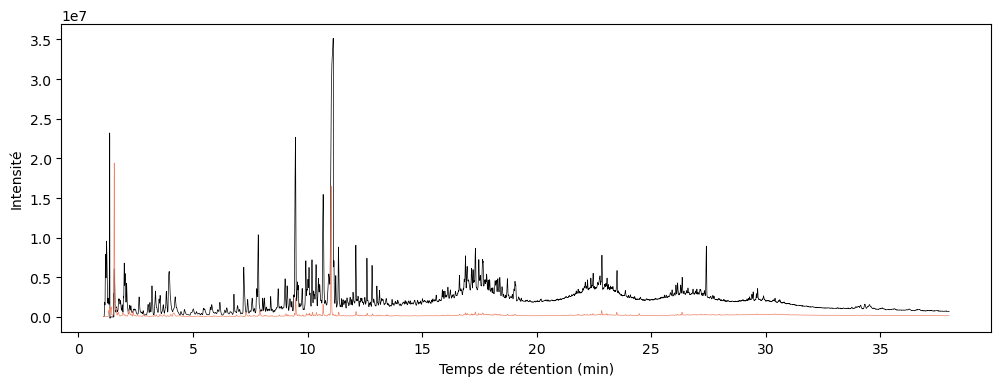

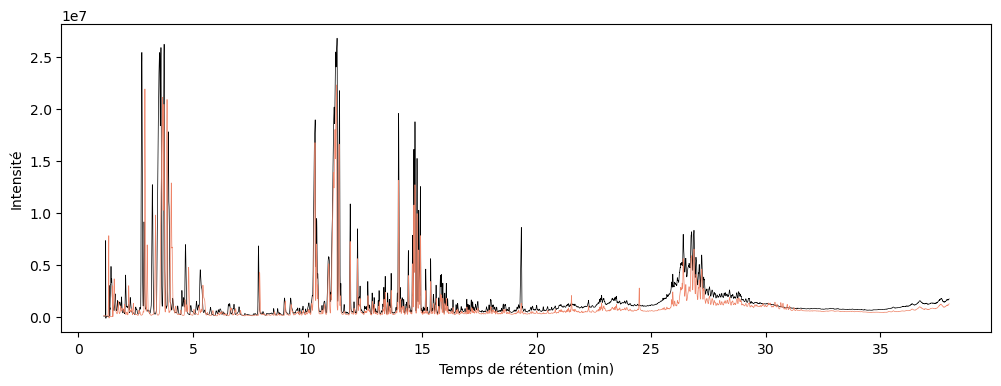

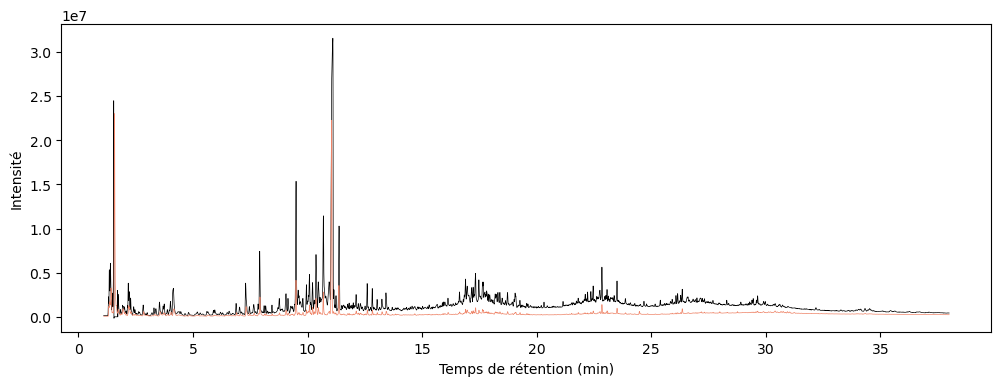

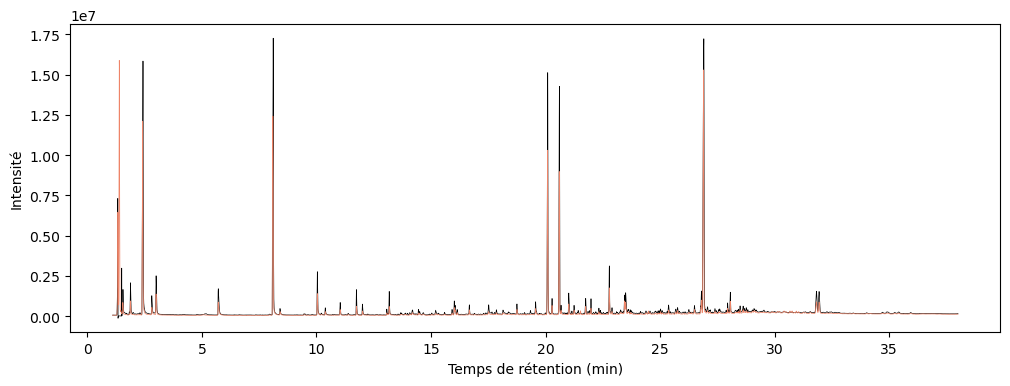

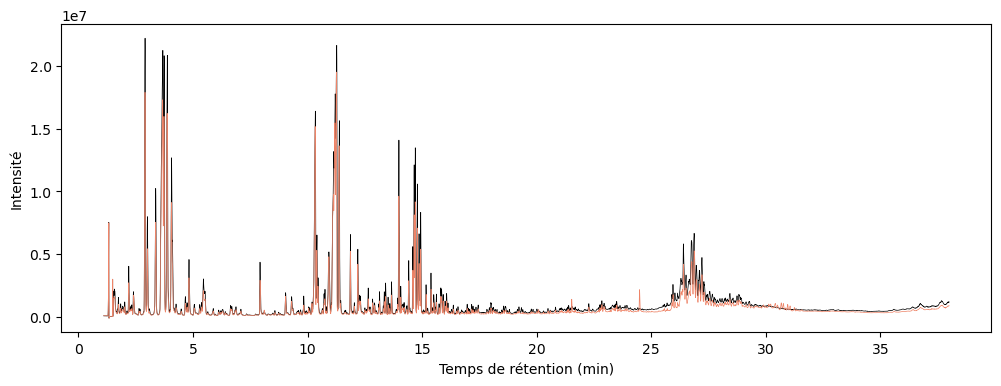

In [24]:
data_raa12 = data[data["tape"]=="raa12"]
data_raa13 = data[data["tape"]=="raa13"]
data_raa14 = data[data["tape"]=="raa14"]
data_raa15 = data[data["tape"]=="raa15"]
data_raa16 = data[data["tape"]=="raa16"]


plot_TIC(data_raa12, 1.1, 38)
plot_TIC(data_raa13, 1.1, 38)
plot_TIC(data_raa14, 1.1, 38)
plot_TIC(data_raa15, 1.1, 38)
plot_TIC(data_raa16, 1.1, 38)

RAA12


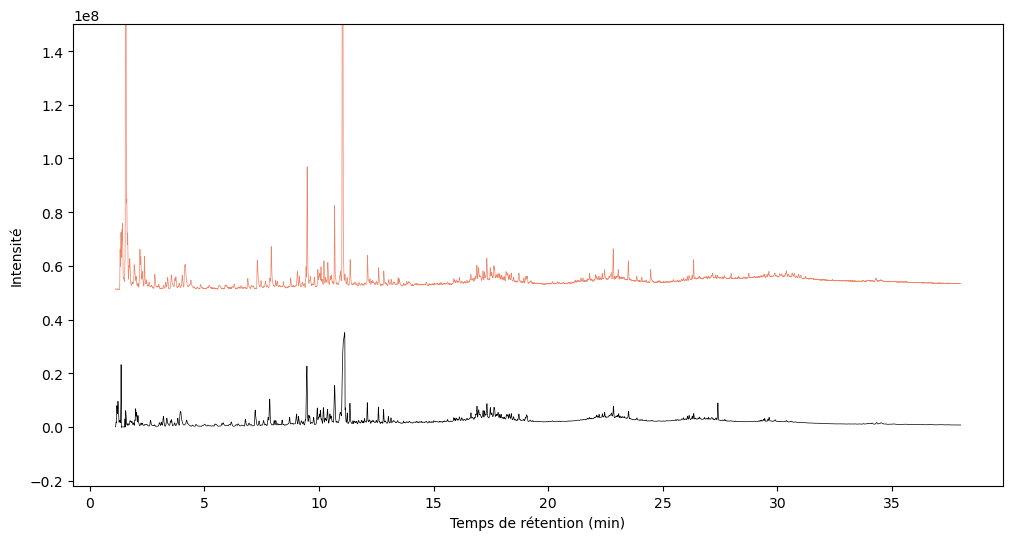

RAA13


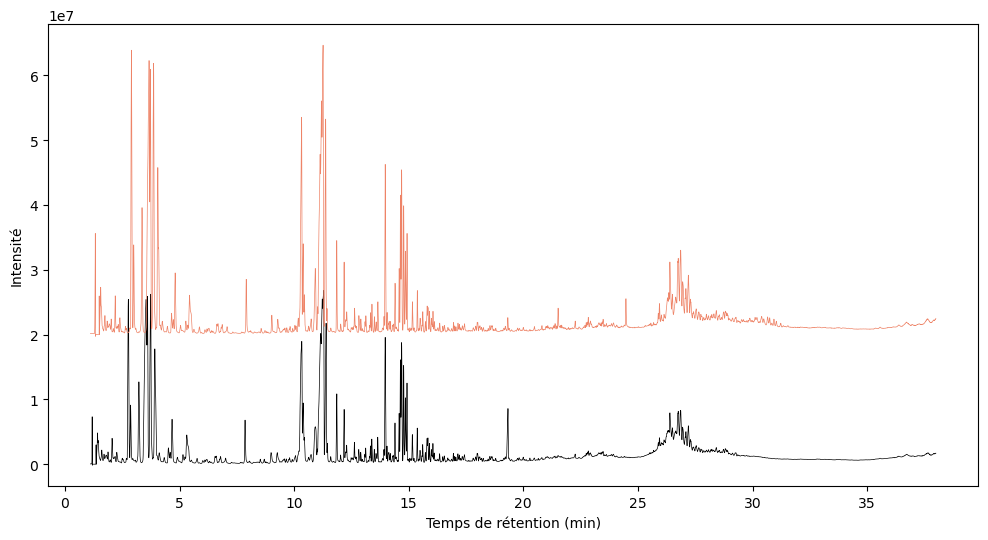

RAA14


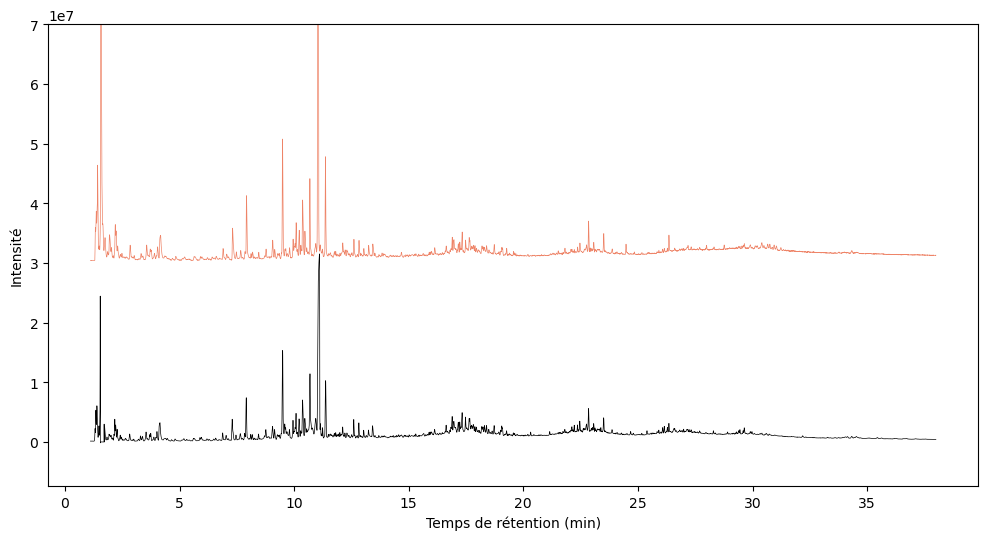

RAA15


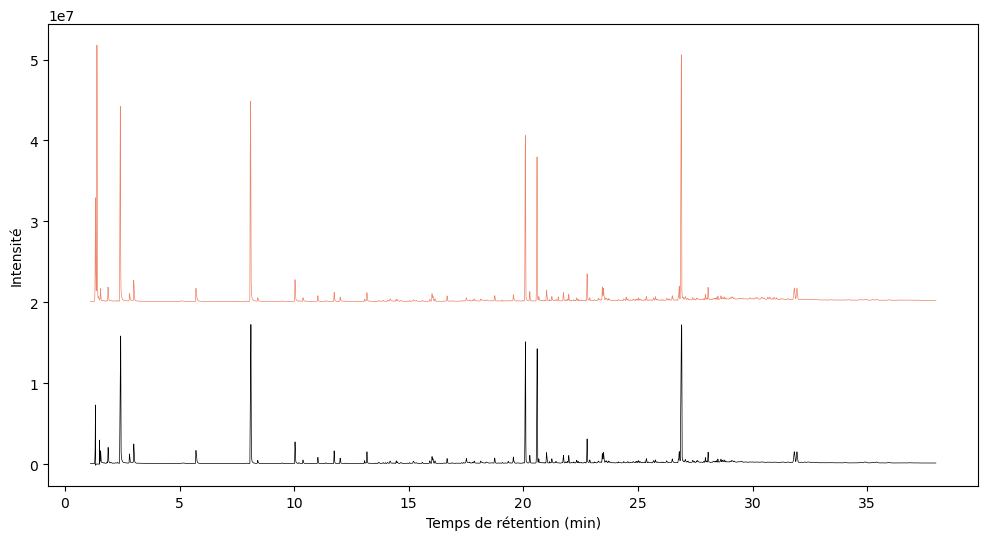

RAA16


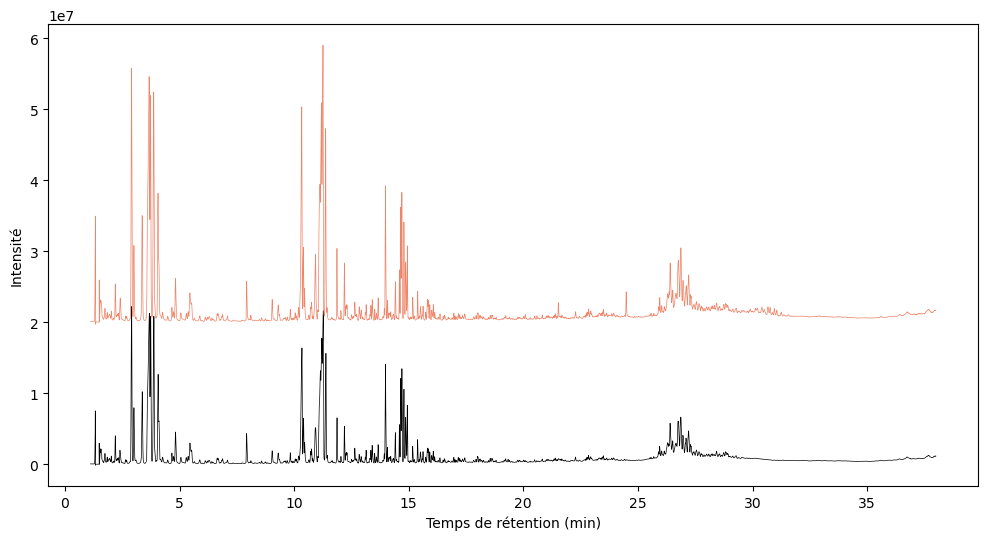

In [35]:
# Applique un décalage verticale aux chromatrogrammes
def v_shift(data, factor, factor2, tape):
    data2 = data.copy()
    numeric_columns = data.columns[2:-2]
    if tape == 12:
        row = 1
    if tape == 13:
        row = 3
    if tape == 14:
        row = 5
    if tape == 15:
        row = 7
    if tape == 16:
        row = 9
    data2.loc[row, numeric_columns] = data.loc[row, numeric_columns].astype(float) * factor + factor2
    return data2

# Annexes 16, 18, 20, 22, 24
print('RAA12')
data_raa12_vshifted = v_shift(data_raa12, 20, 50000000, 12)
plot_TIC(data_raa12_vshifted, 1.11, 38, y_limit_top=150000000, figsize=(12, 6))

print('RAA13')
data_raa13_vshifted = v_shift(data_raa13, 2, 20000000, 13)
plot_TIC(data_raa13_vshifted, 1.11, 38, figsize=(12, 6))

print('RAA14')
data_raa14_vshifted = v_shift(data_raa14, 5, 30000000, 14)
plot_TIC(data_raa14_vshifted, 1.11, 38, y_limit_top=70000000, figsize=(12, 6))

print('RAA15')
data_raa15_vshifted = v_shift(data_raa15, 2, 20000000, 15)
plot_TIC(data_raa15_vshifted, 1.11, 38, figsize=(12, 6))

print('RAA16')
data_raa16_vshifted = v_shift(data_raa16, 2, 20000000, 16)
plot_TIC(data_raa16_vshifted, 1.11, 38, figsize=(12, 6))

## Plot

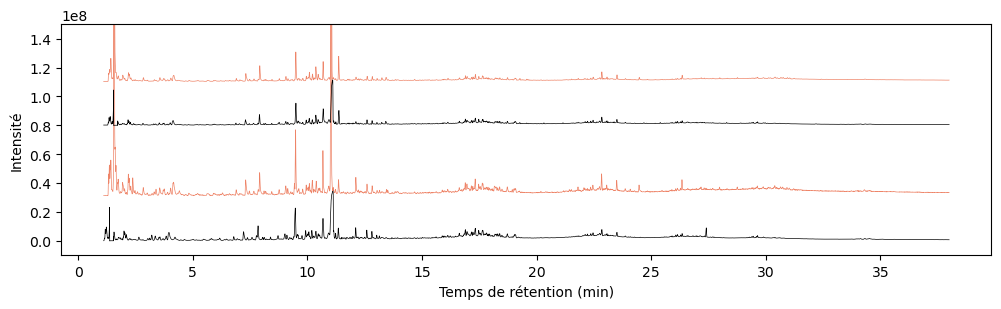

In [37]:
# Figure 14
concatenated_data = pd.concat([data_raa12_vshifted, data_raa14_vshifted], ignore_index=True)

numeric_columns = concatenated_data.columns[2:-2]

concatenated_data.loc[1, numeric_columns] = concatenated_data.loc[1, numeric_columns].astype(float) - 20000000
concatenated_data.loc[2, numeric_columns] = concatenated_data.loc[2, numeric_columns].astype(float) + 80000000
concatenated_data.loc[3, numeric_columns] = concatenated_data.loc[3, numeric_columns].astype(float) + 80000000

plot_TIC(concatenated_data, 1.11, 38, y_limit_top=150000000, y_limit_down=-10000000, figsize=(12, 3))

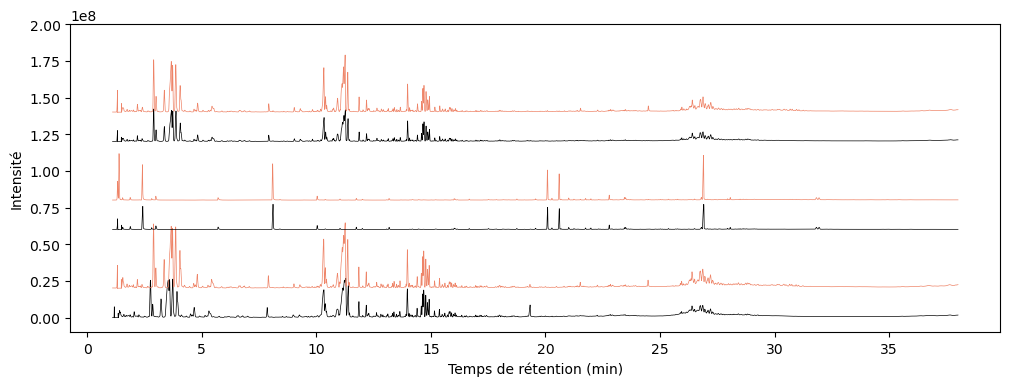

In [47]:
# Figure 18
concatenated_data = pd.concat([data_raa13_vshifted, data_raa15_vshifted, data_raa16_vshifted], ignore_index=True)

numeric_columns = concatenated_data.columns[2:-2]

concatenated_data.loc[1, numeric_columns] = concatenated_data.loc[1, numeric_columns].astype(float) + 0
concatenated_data.loc[2, numeric_columns] = concatenated_data.loc[2, numeric_columns].astype(float) + 60000000
concatenated_data.loc[3, numeric_columns] = concatenated_data.loc[3, numeric_columns].astype(float) + 60000000
concatenated_data.loc[4, numeric_columns] = concatenated_data.loc[4, numeric_columns].astype(float) + 120000000
concatenated_data.loc[5, numeric_columns] = concatenated_data.loc[5, numeric_columns].astype(float) + 120000000

plot_TIC(concatenated_data, 1.11, 38, y_limit_top= 200000000, y_limit_down=-10000000, figsize=(12, 4))